# Временные ряды. Домашнее задание 1

В этом домашнем задании вам предстоит применить инструменты временного анализа на реальных климатических данных. На примере температур по выбранной стране вы отработаете ключевые элементы пайплайна прогнозирования: подготовку временного ряда, корректное разбиение на обучающую и тестовую части, использование скользящего окна, генерацию признаков и обучение простой модели.

Результатом станет ноутбук с кодом, графиками и краткими пояснениями, в котором вы продемонстрируете умение строить базовый прогноз временного ряда и оценивать его качество с помощью метрик.  

Датасет: [Climate Change: Earth Surface Temperature Data](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data)

### Подготовка данных

Загрузите датасет GlobalLandTemperaturesByCountry.csv.

Выберите одну страну (например, Belarus или любую другую) и постройте временной ряд средних месячных температур. Убедитесь, что индекс данных — это дата.

In [136]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### 1.1. Загрузка датасета и фильтрация по стране

In [36]:
# Загрузка датасета
path = kagglehub.dataset_download("berkeleyearth/climate-change-earth-surface-temperature-data")

df = pd.read_csv(path+"/GlobalLandTemperaturesByCountry.csv")
df.head()

Using Colab cache for faster access to the 'climate-change-earth-surface-temperature-data' dataset.


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


В файле отображены глобальные температуры суши по странам.

Описание столбцов:
dt - дата  
AverageTemperature: средняя глобальная температура в градусах Цельсия  
AverageTemperatureUncertainty: 95% доверительный интервал вокруг среднего значения  

In [45]:
# Посмотрим, какие страны есть
df["Country"].unique()

array(['Åland', 'Afghanistan', 'Africa', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica',
       'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Asia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Baker Island', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bhutan', 'Bolivia',
       'Bonaire, Saint Eustatius And Saba', 'Bosnia And Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands', 'Bulgaria',
       'Burkina Faso', 'Burma', 'Burundi', "Côte D'Ivoire", 'Cambodia',
       'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'Christmas Island', 'Colombia', 'Comoros',
       'Congo (Democratic Republic Of The)', 'Congo', 'Costa Rica',
       'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic',
       'Denmark (Europe)', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecu

In [79]:
# Фильтруем по стране
country = "Italy"
df_italy = df.query(f"Country == '{country}'").reset_index()
df_italy.head()

,index,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,261968,1743-11-01,9.538,1.944,Italy
1,261969,1743-12-01,NaN,NaN,Italy
2,261970,1744-01-01,NaN,NaN,Italy
3,261971,1744-02-01,NaN,NaN,Italy
4,261972,1744-03-01,NaN,NaN,Italy


In [80]:
df_italy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          3239 non-null   int64  
 1   dt                             3239 non-null   object 
 2   AverageTemperature             3166 non-null   float64
 3   AverageTemperatureUncertainty  3166 non-null   float64
 4   Country                        3239 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 126.7+ KB


#### 1.2. Преобразование индекса в дату, проверка пропусков/частоты

In [81]:
# преобразуем дату в объект времени
df_italy.dt = pd.to_datetime(df.dt)


In [82]:
# сортируем по времени и переводим данные на временной индекс
df_italy = df_italy.sort_values('dt')
df_italy = df_italy.set_index('dt')
df_italy.head()

,index,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,,
1743-11-01,261968,9.538,1.944,Italy
1743-12-01,261969,NaN,NaN,Italy
1744-01-01,261970,NaN,NaN,Italy
1744-02-01,261971,NaN,NaN,Italy
1744-03-01,261972,NaN,NaN,Italy


In [83]:
# удалим не нужный столбец страны и index
df_italy = df_italy.drop(columns=['Country', 'index'])
df_italy.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1743-11-01,9.538,1.944
1743-12-01,NaN,NaN
1744-01-01,NaN,NaN
1744-02-01,NaN,NaN
1744-03-01,NaN,NaN


In [84]:
df_italy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3239 entries, 1743-11-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             3166 non-null   float64
 1   AverageTemperatureUncertainty  3166 non-null   float64
dtypes: float64(2)
memory usage: 75.9 KB


In [85]:
df_italy

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1743-11-01,9.538,1.944
1743-12-01,NaN,NaN
1744-01-01,NaN,NaN
1744-02-01,NaN,NaN
1744-03-01,NaN,NaN
...,...,...
2013-05-01,15.446,0.341
2013-06-01,19.764,0.415
2013-07-01,23.651,0.448


In [87]:
# проверим наличие пропусков
df_italy.isnull().sum()

,0
AverageTemperature,73
AverageTemperatureUncertainty,73


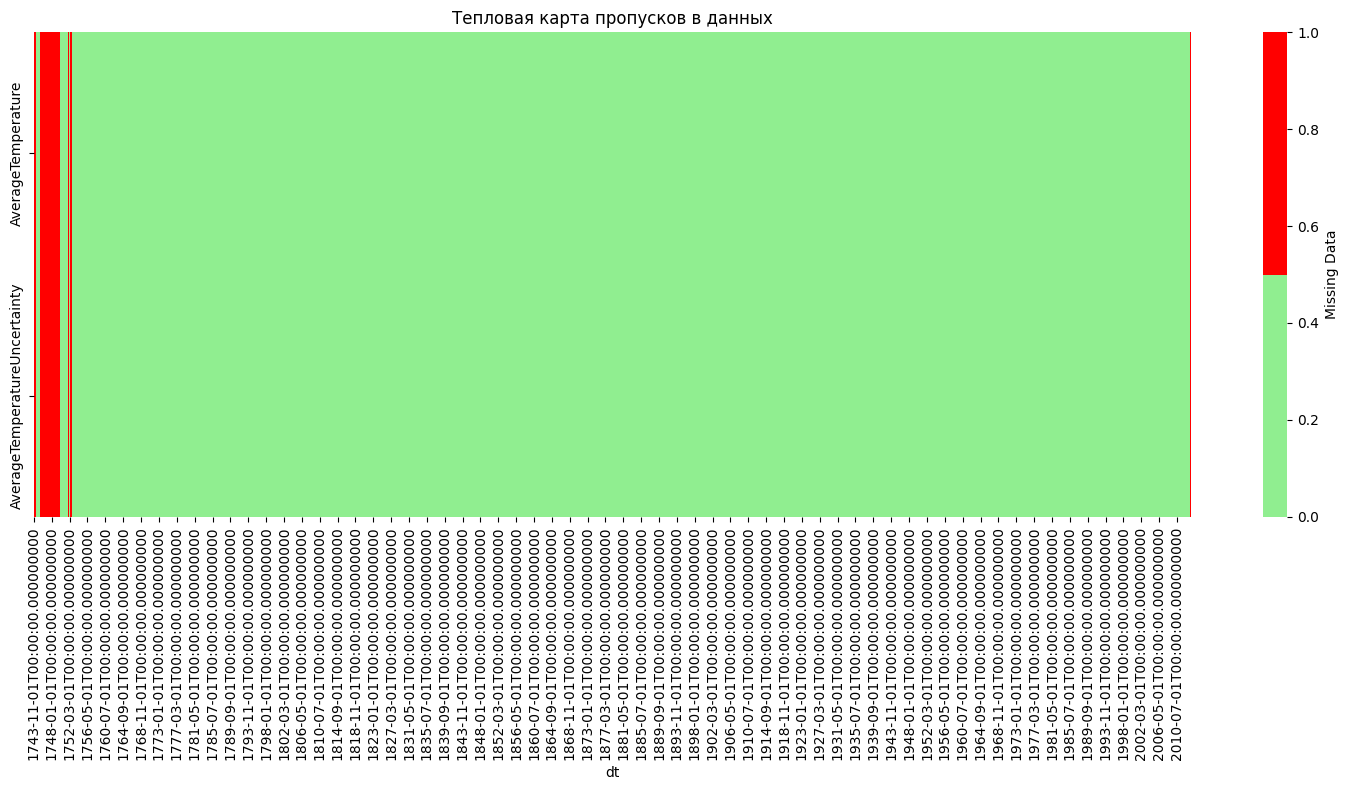

In [88]:
# визуализируем пропуски с помощью тепловой карты, чтобы проверить их частоту
missing_matrix = df_italy.isnull()

plt.figure(figsize=(15, 8))
sns.heatmap(missing_matrix.transpose(),
            cbar=True,
            cmap=['lightgreen', 'red'],  # зеленый = данные есть, красный = пропуски
            cbar_kws={'label': 'Missing Data'},
            linewidths=0.0005)
plt.title('Тепловая карта пропусков в данных')
plt.tight_layout()
plt.show()

In [89]:
df_italy.isnull()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1743-11-01,False,False
1743-12-01,True,True
1744-01-01,True,True
1744-02-01,True,True
1744-03-01,True,True
...,...,...
2013-05-01,False,False
2013-06-01,False,False
2013-07-01,False,False


Всего 73 пропуска из исходных 3239 значений. Пропуски составляют приблизительно 2%. Они расположены по большей части в начале датасета (примерно до 1752 года), и отчасти в конце (в 2013 году).

Выбираем стратегию удалить пропуски, поскольку их количество незначительно, и основная часть данных с 1752 до 2012 пропусков не имеет.

In [90]:
df_italy = df_italy.dropna()
df_italy.isnull().sum()

,0
AverageTemperature,0
AverageTemperatureUncertainty,0


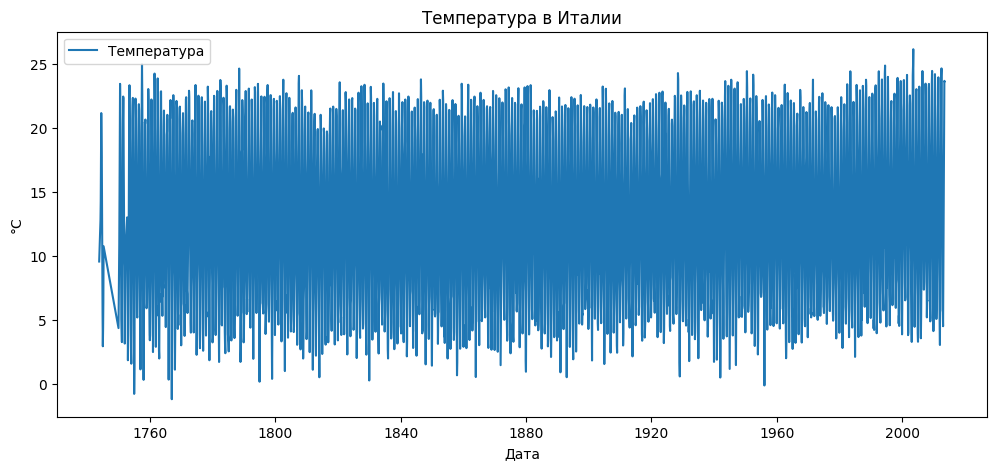

In [91]:
# Проверим, что данные имеют регулярную частоту
plt.figure(figsize=(12,5))
plt.plot(df_italy.index, df_italy["AverageTemperature"], label="Температура")
plt.title("Температура в Италии")
plt.xlabel("Дата")
plt.ylabel("°C")
plt.legend()
plt.show()

В исходных данных частота по месяцам

Можем видеть на графике, что в начале есть резкий скачок. Это связано с тем, что пропуски, которые мы удаляли на предыдущем шаге, не все шли друг за другом в датасете, а между ними были строки с данными. Эти данные до 1752 года включительно, как видели на тепловой карте. Найдем месяц, после которого пропусков не было, и отфильтруем ряд для дальнейшей работы.

In [99]:
df_italy.head(50)

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1743-11-01,9.538,1.944
1744-04-01,12.759,2.095
1744-05-01,14.236,1.820
1744-06-01,18.479,1.863
1744-07-01,21.132,1.904
1744-09-01,17.660,1.938
1744-10-01,13.083,1.928
1744-11-01,9.267,1.833
1744-12-01,5.432,1.924


Мы видим резкий скачок между апрелем 1745 и январем 1750
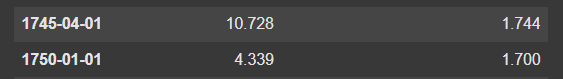

а также между сентябрем 1751 и январем 1752  
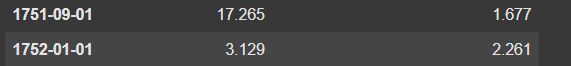

а также с апреля по октябрь 1752  
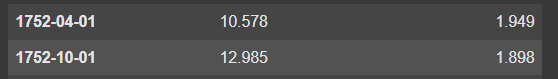

In [101]:
# Отфильтруем временной ряд с 1752-10-01
ts = df_italy['1752-10-01':'2013-09-01']

In [106]:
# Проверка частоты после фильтрации
print(f"Уникальные интервалы между датами:")
date_diffs = ts.index.to_series().diff().value_counts()
print(date_diffs.head())

print(f"\nПериод: {ts.index.min()} - {ts.index.max()}")
print(f"Всего наблюдений: {len(ts)}")

Уникальные интервалы между датами:
dt
31 days    1826
30 days    1043
28 days     198
29 days      63
Name: count, dtype: int64

Период: 1752-10-01 00:00:00 - 2013-08-01 00:00:00
Всего наблюдений: 3131


Интервалы между датами соотвествут количеству дней в месяцах. Делаем вывод, что частота ежемесячная.

#### 1.3 Построение базового графика временного ряда

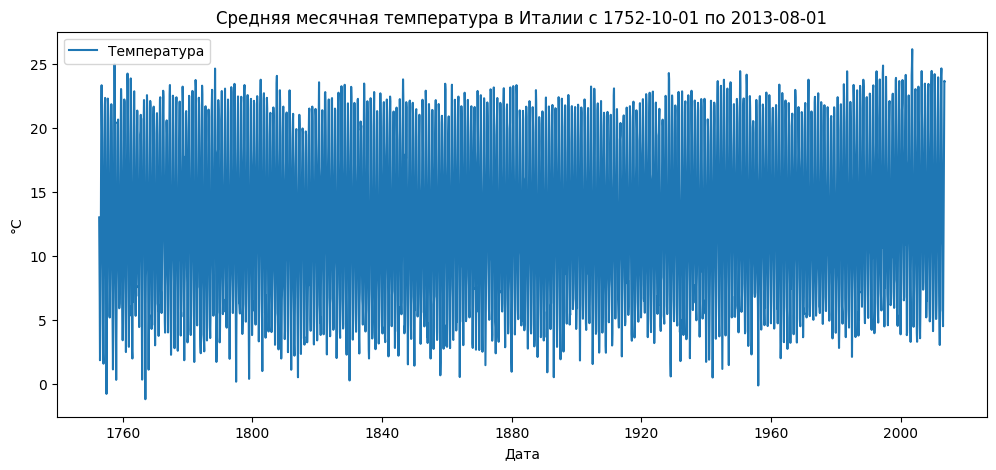

In [108]:
# Построение базового графика временного ряда
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts["AverageTemperature"], label="Температура")
plt.title("Средняя месячная температура в Италии с 1752-10-01 по 2013-08-01")
plt.xlabel("Дата")
plt.ylabel("°C")
plt.legend()
plt.show()

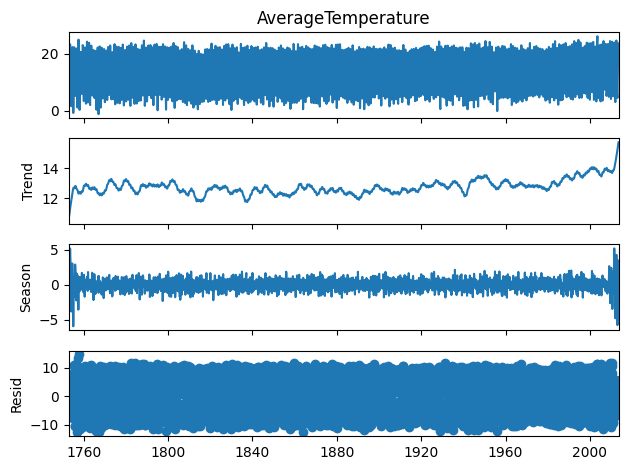

In [110]:
# Дополнительно сделаем STL декомпозицию, чтобы посмотреть наличие трнеда, сезонности и шума
from statsmodels.tsa.seasonal import STL
stl = STL(ts["AverageTemperature"], period=29)
res = stl.fit()

res.plot()
plt.show()

Разложение показало, что средняя месячная температура в Италии имеет небольшой позитивный тренд и сезонность. На графике сезонности видны регулярные колебания. Однако стоит отметить, что для более серьезных выводов и наглядной визуализации возможно стоит сделать downsampling и рассмотреть ежегодные данные вместо ежемесячных.

### Holdout-разбиение

Разделите временной ряд: первые 80% наблюдений оставьте для обучения, оставшиеся 20% — для теста.

Визуализируйте train/test на одном графике.

#### 2.1. Корректное деление 80% train / 20% test по времени

In [112]:
# деление 80% train / 20% test по времени

train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

print(f"Размер train: {len(train)}, размер test: {len(test)}")

Размер train: 2504, размер test: 627


#### 2.2. Визуализация train/test на одном графике

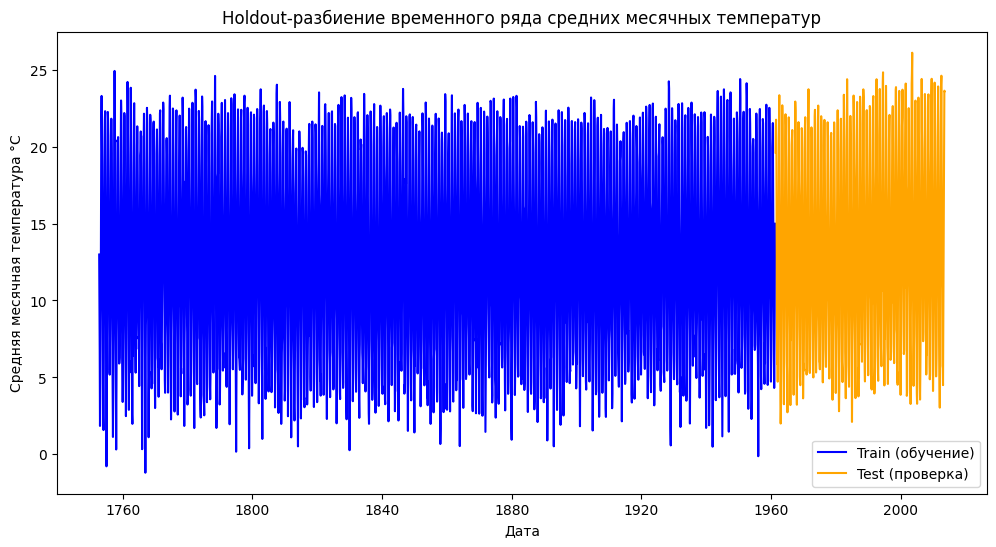

In [115]:
plt.figure(figsize=(12,6))

# Train
plt.plot(train.index, train['AverageTemperature'], label='Train (обучение)', color='blue')

# Test
plt.plot(test.index, test['AverageTemperature'], label='Test (проверка)', color='orange')

# Оформление
plt.title("Holdout-разбиение временного ряда средних месячных температур")
plt.xlabel("Дата")
plt.ylabel("Средняя месячная температура °C")
plt.legend()
plt.show()

Видим, что временной ряд успешно поделили на обучающую и тестовую выборки.

### Скользящее окно   Rolling window (backtesting)

Реализуйте rolling-window-разбиение: обучающие отрезки длиной 120 месяцев (10 лет) и прогнозный горизонт 12 месяцев. Визуализируйте хотя бы первые два сплита.

#### 3.1. Реализация скользящего окна (120 мес. обучение, 12 мес. прогноз)

In [119]:
window_size = 120   # месяцев для обучения
horizon = 12  	    # месяцев для прогноза

ts_size = len(ts)

# Соберем окна
splits = []
for start in range(0, ts_size - window_size - horizon + 1, horizon):
	train_window = ts.iloc[start:start+window_size]
	test_window = ts.iloc[start+window_size:start+window_size+horizon]
	splits.append((train_window, test_window))

#### 3.2. Визуализация хотя бы двух первых сплитов

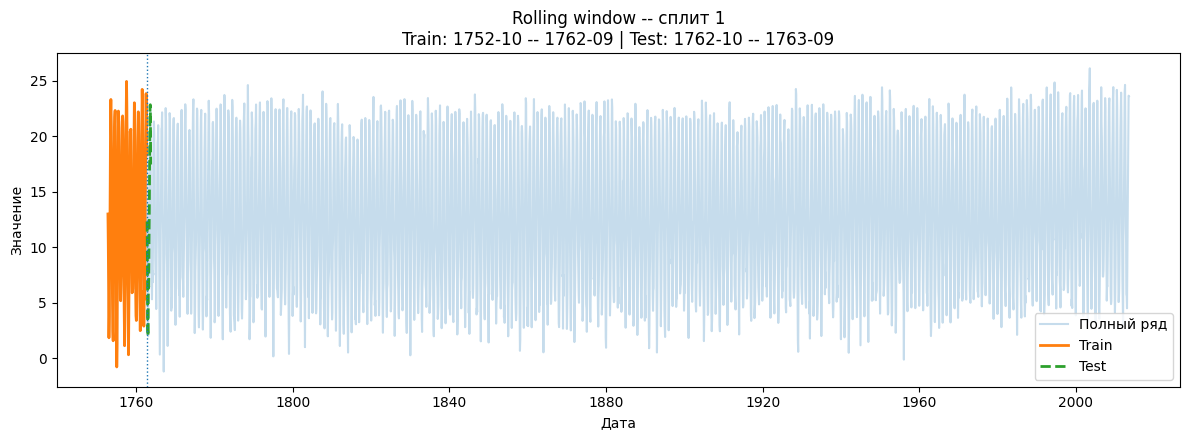

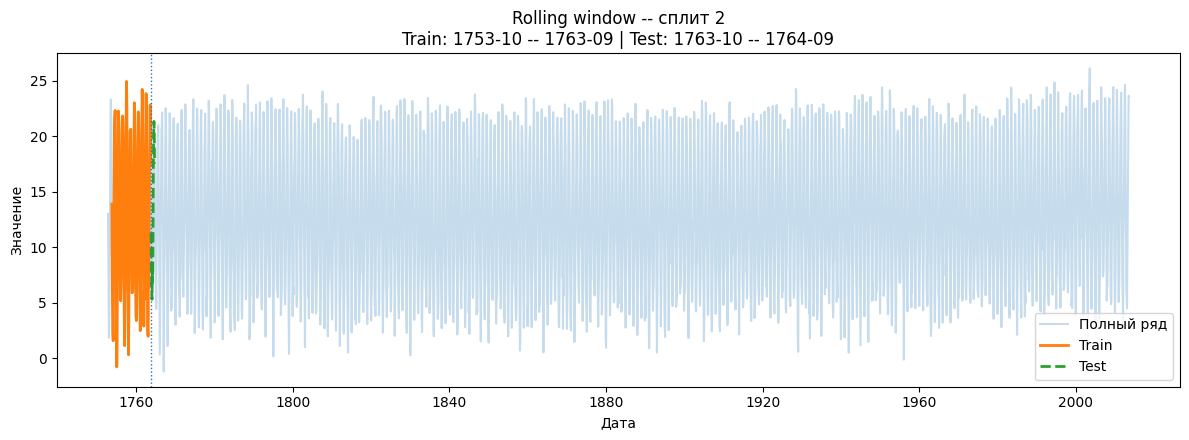

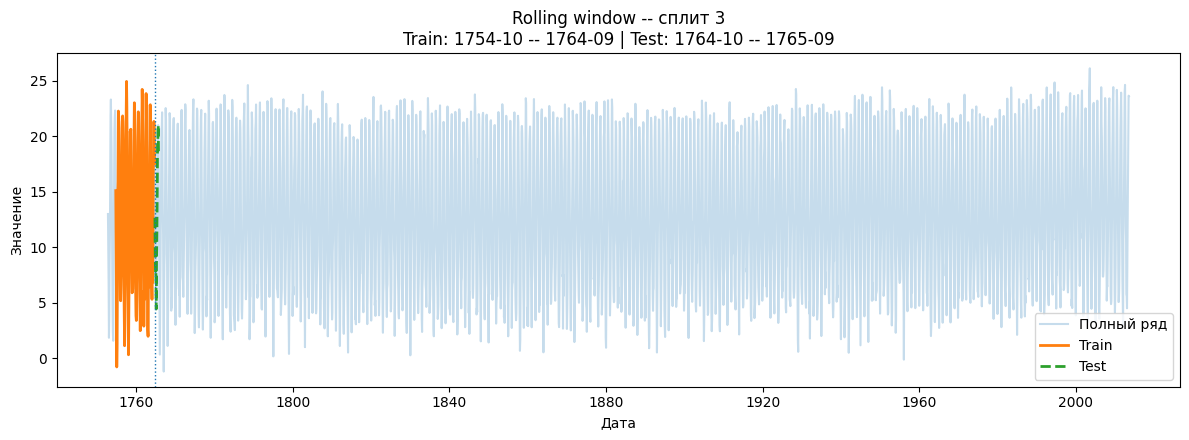

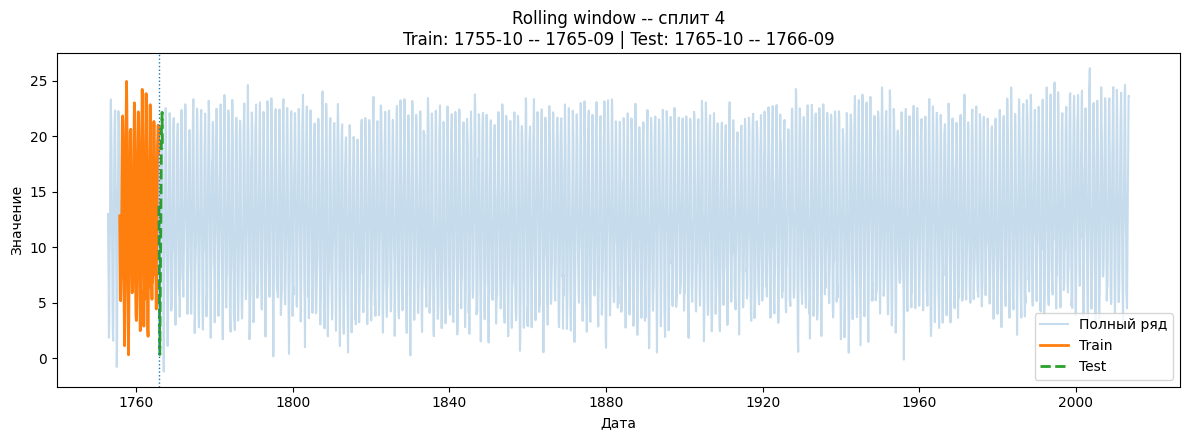

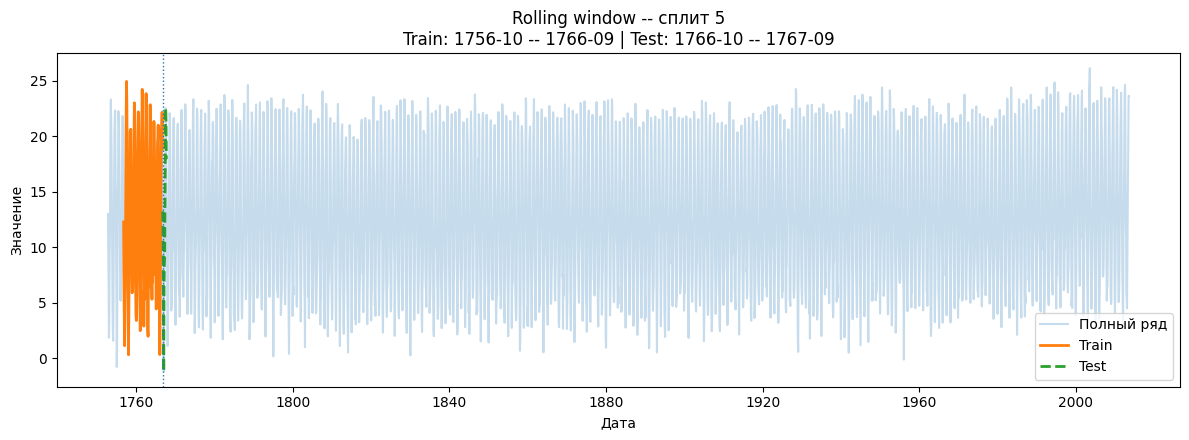

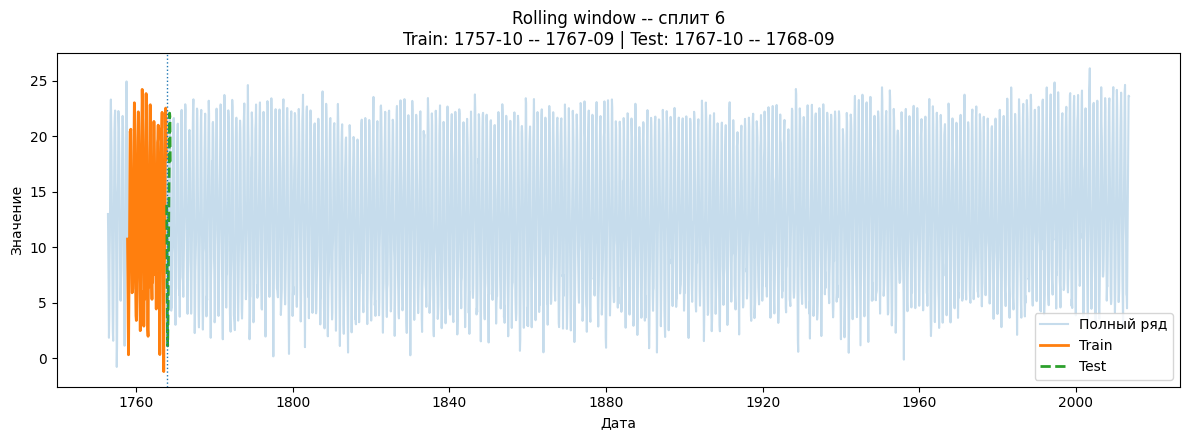

In [122]:
# Визуализируем первые 6 сплитов
for i, (train_window, test_window) in enumerate(splits[:6], start=1):
	plt.figure(figsize=(12, 4.5))

	# Весь ряд — фоном
	plt.plot(ts.index, ts['AverageTemperature'], alpha=0.25, label='Полный ряд')
	# Train
	plt.plot(train_window.index, train_window['AverageTemperature'], linewidth=2, label='Train')
	# Test
	plt.plot(test_window.index, test_window['AverageTemperature'], linewidth=2, linestyle='--', label='Test')
	# Вертикальная линия-раздел
	plt.axvline(test_window.index[0], linestyle=':', linewidth=1)

	plt.title(f'Rolling window -- сплит {i}\n'
          	f'Train: {train_window.index[0].strftime("%Y-%m")} -- {train_window.index[-1].strftime("%Y-%m")} | '
          	f'Test: {test_window.index[0].strftime("%Y-%m")} -- {test_window.index[-1].strftime("%Y-%m")}')
	plt.xlabel('Дата')
	plt.ylabel('Значение')
	plt.legend()
	plt.tight_layout()
	plt.show()

Мы реализовали стратегию скользящего окна: многократно разделили временной ряд на обучающую часть (120 месяцев) и тестовую часть (12 месяцев), визуализировали первые сплиты и убедились, что проверка всегда проводится на будущих значениях. В итоге мы видим последовательные окна на графиках: модель учится на 10 годах (120 месяцев) подряд и проверяется на следующем году (12 месяцев). Затем окно сдвигается на год вперед.


### Генерация признаков

Для временного ряда создайте лаги (например, на 1 и 12 месяцев) и календарные признаки: номер месяца и индикатор зимнего сезона (декабрь — февраль).

Покажите первые строки получившегося датафрейма.

Создадим лаги и признаки для уже разделенных тренировочной и тестовой выборок

#### 4.1. Создание лагов (t-1, t-12)

In [130]:
train['lag_1'] = train['AverageTemperature'].shift(1)  # Значение месяц назад
train['lag_12'] = train['AverageTemperature'].shift(12)  # Значение 12 месяцев (год) назад

test['lag_1'] = test['AverageTemperature'].shift(1)
test['lag_12'] = test['AverageTemperature'].shift(12)

/tmp/ipython-input-3399848638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lag_1'] = train['AverageTemperature'].shift(1)  # Значение месяц назад
/tmp/ipython-input-3399848638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lag_12'] = train['AverageTemperature'].shift(12)  # Значение 12 месяцев (год) назад
/tmp/ipython-input-3399848638.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

#### 4.2. Создание календарных признаков (номер месяца, индикатор зимы)

In [131]:
# номер месяца
train['month'] = train.index.month
# индикатор зимы (номер месяца: 12 - декабрь, 1 - январь или 2 - февраль)
train['is_winter'] = train['month'].isin([12, 1, 2]).astype(int)

test['month'] = test.index.month
test['is_winter'] = test['month'].isin([12, 1, 2]).astype(int)

/tmp/ipython-input-69173172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
/tmp/ipython-input-69173172.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_winter'] = train['month'].isin([12, 1, 2]).astype(int)
/tmp/ipython-input-69173172.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

#### 4.3. Вывод первых строк датафрейма с признаками

In [138]:
# Удалим строки со значениями NaN, которые появились после создания лагов
train = train.dropna()
test = test.dropna()

In [139]:
print("Первые строки тренировочного датафрейма с признаками")
train.head()

Первые строки тренировочного датафрейма с признаками


,AverageTemperature,AverageTemperatureUncertainty,lag_1,lag_12,month,is_winter
dt,,,,,,
1753-10-01,13.868,1.586,18.863,12.985,10,0
1753-11-01,7.744,2.412,13.868,10.262,11,0
1753-12-01,4.717,3.088,7.744,6.732,12,1
1754-01-01,2.381,3.661,4.717,1.828,1,1
1754-02-01,1.558,5.645,2.381,3.777,2,1


In [140]:
print("Первые строки тестового датафрейма с признаками")
test.head()

Первые строки тестового датафрейма с признаками


,AverageTemperature,AverageTemperatureUncertainty,lag_1,lag_12,month,is_winter
dt,,,,,,
1962-06-01,18.432,0.511,14.632,19.622,6,0
1962-07-01,21.666,0.361,18.432,21.262,7,0
1962-08-01,23.354,0.345,21.666,21.761,8,0
1962-09-01,19.231,0.234,23.354,20.549,9,0
1962-10-01,14.476,0.407,19.231,14.748,10,0


### Оценка прогноза

Постройте простую модель (например, линейную регрессию, где целевая переменная — температура, а признаки — лаги и дата-фичи).

Сделайте прогноз на тестовой выборке из holdout-разбиения.

Посчитайте метрики MAE, RMSE и MAPE.

#### Моделирование и прогноз

#### 5.1. Обучение простой модели (линейная регрессия)

In [141]:
# целевая переменная — температура, а признаки — лаги и дата-фичи
features = ['lag_1', 'lag_12', 'month', 'is_winter']
X_train = train[features]
y_train = train['AverageTemperature']

X_test = test[features]
y_test = test['AverageTemperature']

print(f"Размер X_train: {X_train.shape}, размер y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}, размер y_test: {y_test.shape}")

# оубчаем линейную регрессию
model = LinearRegression()
model.fit(X_train, y_train)

Размер X_train: (2492, 4), размер y_train: (2492,)
Размер X_test: (615, 4), размер y_test: (615,)


LinearRegression()

#### 5.2. Прогноз на тестовой выборке holdout

In [142]:
y_pred = model.predict(X_test)

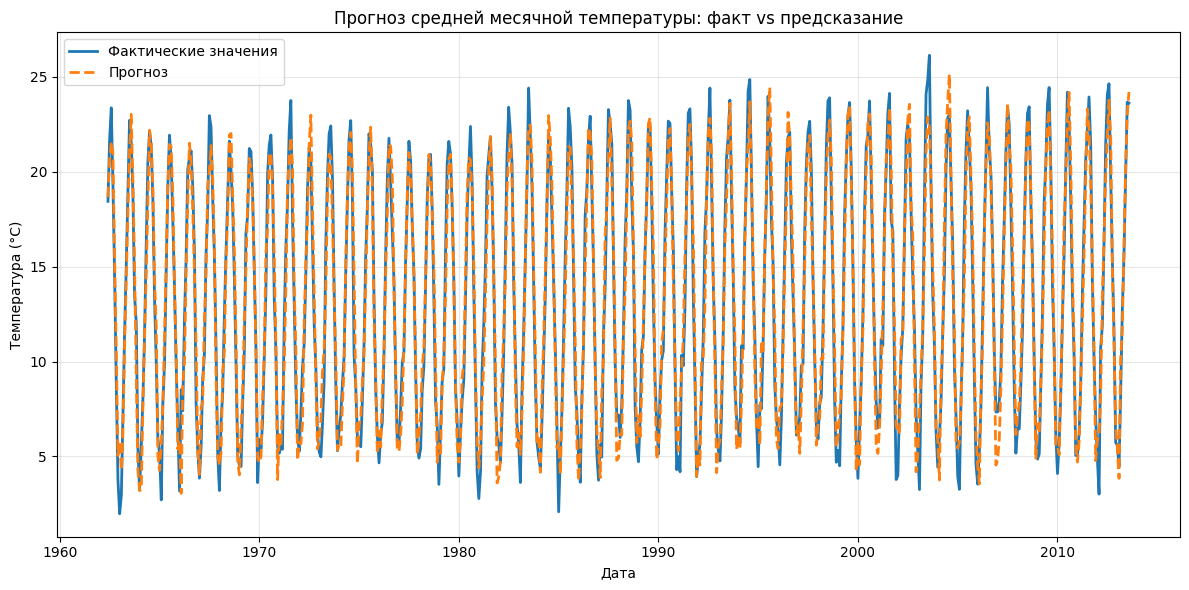

In [144]:
# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Фактические значения', linewidth=2)
plt.plot(X_test.index, y_pred, label='Прогноз', linewidth=2, linestyle='--')
plt.title('Прогноз средней месячной температуры: факт vs предсказание')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

####  Метрики и интерпретация

#### 6.1. Расчет MAE, RMSE, MAPE

In [150]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f} %")

MAE: 1.1924
RMSE: 1.4643
MAPE: 13.1894 %


#### 6.2. Краткий комментарий (1-2 предложения о качестве прогноза)

Модель показывает хорошее качество прогноза!  

Средняя абсолютная ошибка составляет около 1.2. То есть, модель в среднем ошибается в градусах Цельсия на 1.2 градуса, что вполне приемлемо для температурных прогнозов в реальной жизни.

Среднеквадратичная ошибка составляет приблизительно 1.5 градуса Цельсия. Мы знаем, что RMSE штрафует за большие ошибки, поскольку чувствительна к выбросам. Но поскольку полученное значение небольшое (отличается от MAE менее чем на 0.5) мы можем сказать, что эти ошибки прогноза модели не критичны, выбросов с большими ошибками нет.

Анализируя значение средней абсолютной процентной ошибки, можем сказать, что модель ошибается в среднем на 13%. Это приемлемый результат для прогнозов средних месячных температур с помощью простой модели.